# Resilient Edge

Making edge computing infrastructure resilient to power outages.

## Description

The internet of things (IoT) and edge computing are core components of future smart cities. Interconnected computing systems will perform tasks beyond measuring and monitoring, and will also make decisions and take over highly critical tasks. Especially in disaster situations, such as extreme weather events, where for e.g. traffic control can be crucial to guarantee safety, we should therefore not rely on grid power supply to be available at all times.

In this challenge, students will investigate how to manage an edge computing node resilient against power outages by relying on on-site renewable energy generation and a battery. The node will be running a critical service that may never stop and can optionally take over workloads of lower priority if energy availability allows. Within this scenario, students can develop solutions for a variety of problems, such as: How should the edge node be managed in order to accept as many optional workloads as possible without risking power outage? How risky are different solutions to this problem? Can we use weather forecasts to improve our results? Can we maybe delay some non-urgent workloads and compute them when the sun is shining?

The objective of this challenge is to learn to use simulation and datasets to investigate abstract problems. Solutions to this challenge can either be technical and involve some programming, or you can use the simulation to back your conceptual ideas with some experimental data.

## Required/Suggested Tools and Data

You are free to use any libraries or tools that help you researching the problem or supporting your ideas. This tutorial will cover:

- [SimPy](https://simpy.readthedocs.io/): Python discrete-event simulation framework
- [LEAF](https://github.com/dos-group/leaf): Simulator for modeling energy consumption in edge computing based on SimPy
- [PyBaMM](https://github.com/pybamm-team/PyBaMM): Fast and flexible physics-based battery models in Python

You are also free to use any publicly available datasets in your data analysis or simulations. The repository contains two ready-to-use datasets:

- `data/weather_berlin_2022-06.csv` containts minutely measurements of solar irradiance and wind speed in June 2021 in Berlin
- `taxi_2021-06.csv` contains data on taxi trips during the same period

All further information is explained below.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

## Weather Data

Solar irradiance and other weather time series can be useful to simulate the produced energy at your edge node. The repository includes `data/weather_berlin_2022-06.csv`, which contains minutely measurements of solar irradiance and wind speed in June 2021 in Berlin ([permalink](https://wetter.htw-berlin.de/History/EGH_SMP4,VWI_ANE1/2021-06-01/2021-06-30)). Additional weather data can be obtained from https://wetter.htw-berlin.de.

Solar irradiance is reported in W/m², wind speed in m/s.

In [2]:
with open("data/weather_berlin_2021-06.csv", "r") as csvfile:
    weather_df = pd.read_csv(csvfile, parse_dates=True, index_col=0)
weather_df["2021-06-01 12:00:00":"2021-06-01 12:05:00"]

,solar,wind
time,,
2021-06-01 12:00:00,549,4.2
2021-06-01 12:01:00,546,3.6
2021-06-01 12:02:00,552,4.7
2021-06-01 12:03:00,549,1.9
2021-06-01 12:04:00,540,4.8
2021-06-01 12:05:00,540,3.5


### Convert solar irradiance to power output

You can use weather data to compute the available power generated at your edge node. For example, for solar power (W) a simple formular is solar irradiance (W/m²) times the area of your solar panel (m²) times the efficiency of the solar pannel (usually around 18%).

<AxesSubplot:xlabel='time'>

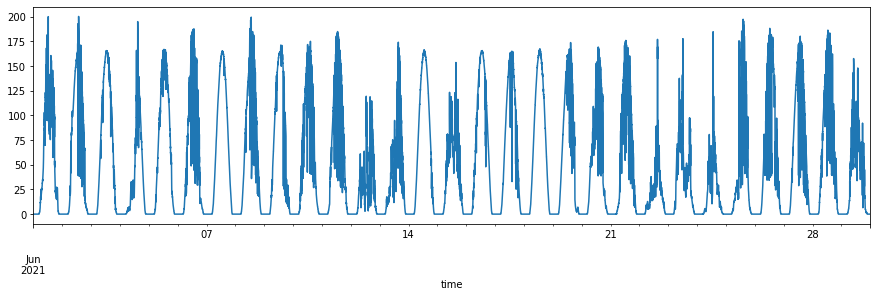

In [3]:
pv_efficiency = 0.18
pv_area = 1 # m^2
solar = weather_df.solar * pv_area * pv_efficiency
solar.plot(figsize=(15,4))

## Taxi Data

We furthermore provide a dataset with taxi rides during the same period. The usage of this data is optional but can be useful to model comutational load. However, you can also assume constant load, use other (artificial) data, etc.

- `taxi_2021-06.csv` contains one row per taxi ride, with information on the *pickup_date*, *dropoff_date*, *passenger_count*, and *trip_duration* in seconds.
- `taxi_count_2021-06.csv` contains the same data reformatted using the code below. There is one row for each minute in the month with information on the *taxi_count* and *passenger_count* within that minute. Feel free to adapt the script for your use case.

In [4]:
with open("data/taxi_2021-06.csv", "r") as csvfile:
    taxi_rides_df = pd.read_csv(csvfile)
taxi_rides_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_duration
0,2021-06-01 00:00:13,2021-06-01 00:07:27,2,434.0
1,2021-06-01 00:01:01,2021-06-01 00:09:28,1,507.0
2,2021-06-01 00:01:13,2021-06-01 00:34:25,4,1992.0
3,2021-06-01 00:02:49,2021-06-01 00:10:48,1,479.0
4,2021-06-01 00:03:27,2021-06-01 00:15:10,1,703.0


We can use pandas to modify this data for it to be easier to use in our experiments

In [5]:
taxi_rides_df.pickup_datetime = pd.to_datetime(taxi_rides_df.pickup_datetime)
group = taxi_rides_df.groupby(pd.Grouper(freq='1min', key='pickup_datetime'))
taxi_df = group.agg({"dropoff_datetime": "count", 'passenger_count': 'sum'})
taxi_df = taxi_df.rename(columns={"dropoff_datetime": "taxi_count"})
# Saving aggregated dataset to disc
with open("data/taxi_count_2021-06.csv", "w") as csvfile:
    taxi_df.to_csv(csvfile)
taxi_df["2021-06-01 12:00:00":"2021-06-01 12:05:00"]

,taxi_count,passenger_count
pickup_datetime,,
2021-06-01 12:00:00,0,0
2021-06-01 12:01:00,0,0
2021-06-01 12:02:00,1,5
2021-06-01 12:03:00,5,13
2021-06-01 12:04:00,3,4
2021-06-01 12:05:00,2,3


### Taxis per 15 min vs. solar production during Jun 1-5

This is examplary code that compares the number of taxis that passed our edge node within 15min with the current power generation.

<AxesSubplot:xlabel='pickup_datetime', ylabel='Taxis per 15min'>

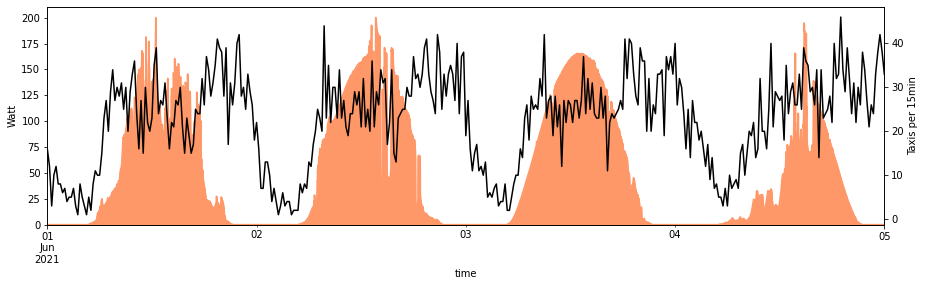

In [6]:
# Group number of taxis per 15min
taxi_count = taxi_df["taxi_count"]
taxi_count_15min = taxi_count.groupby(pd.Grouper(freq='15min')).sum()

# Plot solar
fig, ax1 = plt.subplots()
ax1.set_ylabel("Watt")
solar_slice = solar["2021-06-01 00:00:00":"2021-06-05 00:00:00"]
solar_slice.plot.area(figsize=(15,4), color="#ff9869", ax=ax1)

# Plot taxis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("Taxis per 15min")
taxi_count_slice = taxi_count_15min["2021-06-01 00:00:00":"2021-06-05 00:00:00"]
taxi_count_slice.plot(figsize=(15,4), color="black", ax=ax2)

## Simulating using LEAF

LEAF is a simulator for energy-aware modelling of computing environments based on [SimPy](https://simpy.readthedocs.io/en/latest) and [NetworkX](https://networkx.org).

It's easier to understand if you make yourself familiar with SimPy, a process-based discrete-event simulation (DES) framework, first using their documentation. As I expect most groups to work on a single edge node, you don't need to read up on NetworkX. However, you are of course also welcome to explore the problem in a distributed setting wiht multiple edge nodes.

To get started with LEAF, please refer to the [simple example](https://github.com/dos-group/leaf/blob/main/examples/1_single_node.py).

---

### Example

In our example here, we will simulate a single edge node over the course of 5 days.
Every taxi that passes the edge node will add a task (i.e. computational workload) on the node that will be computed for one minute.

We use two SimPy processes:
- One process adds and removes tasks to the node
- One process charges/discharges a battery on every timestep (one minute)

Note: Take care no to confuse power (in watt (W)) with energy (in watt-hours (Wh) or joule (J = Ws)).

In [7]:
import numpy as np
import leaf
import simpy

from leaf.infrastructure import Node
from leaf.application import Task
from leaf.power import PowerModelNode

First, we implement a _simple_ battery that does not model any loss when charging or discharging.

In [8]:
class Battery:
    """(Way too) simple battery."""
    def __init__(self, capacity, charge_level=0):
        self.capacity = capacity
        self.charge_level = charge_level

    def update(self, energy):
        """Can be called during simulation to feed or draw energy.
        
        If `energy` is positive the battery is charged.
        If `energy` is negative the battery is discharged.
        
        Returns the excess energy after the update:
        - Positive if your battery is fully charged
        - Nevative if your battery is empty
        - else 0
        """
        self.charge_level += energy
        excess_energy = 0
        
        if self.charge_level < 0:
            excess_energy = self.charge_level
            self.charge_level = 0
        elif self.charge_level > self.capacity:
            excess_energy = self.charge_level - self.capacity
            self.charge_level = self.capacity

        return excess_energy

Now we implement the two processes.

- The `task_placement()` process will get the taxi_count series and will place as many tasks on the edge node, as there are taxis at this timestep. You can treat *mips* as an imaginary unit for computational load. Our node will have a maximum capacity of 50 mips - the maximum number of cars per minute in `taxi_count` is 48, so at peak times the fog node will almost be at full load.
- The `power_usage()` process measures the current energy consumption of the node at every timestep, computes the energy delta for that timestep and tries to charge/discharge the battery. Furthermore, it stores the generated and consumed energy, the delta and excess energy, and current battery charging state in global variables for analysis.

In [9]:
def task_placement(env, taxi_count):
    # step through the list (minute by minute)
    for number_of_tasks in taxi_count:
        # create tasks
        tasks = [Task(mips=1) for _ in range(number_of_tasks)]
        # place tasks
        for task in tasks:
            task.allocate(node)
        # pause the process for one timestep
        yield env.timeout(1)
        # remove tasks
        for task in tasks:
            task.deallocate()

def power_usage(env, node, battery, power_production, measurements):
    # step through the power production (minute by minute)
    for production in power_production:
        # get current power usage of node
        consumption = node.measure_power().total()
        # the energy delta per timestep is power * 1/60 Wh
        delta_energy = (production - consumption) / 60
        # charge/discharge battery
        excess_energy = battery.update(delta_energy)
        # Store measurements
        measurements.append({
            "production_power": production,
            "consumption_power": consumption,
            "delta_energy": delta_energy,
            "excess_energy": excess_energy,
            "battery_charge_level": battery.charge_level,
        })
        # pause the process for one timestep
        yield env.timeout(1)

Next, we instantiate and execute our simulaton.

Every `Node` in LEAF has a `PowerModelNode`. The parameter *max_power* describes its power usage at full load, *static_power* when there is no load at all. For simpliciy we say our node does not consume any energy when idle, and 100W under full load

Our battery will have a maximum capactiy of 10000Wh and an initial charge level of 4000Wh.

In [10]:
measurements = []  # this will contain the resulting measurements

MAX_POWER = 600  # W
STATIC_POWER = 50  # W
BATTERY_CAPACITY = 2000  # Wh
BATTERY_CHARGE_LEVEL = 1000  # Wh

node = Node(name="node1", mips=50, power_model=PowerModelNode(max_power=MAX_POWER, static_power=STATIC_POWER))
battery = Battery(capacity=BATTERY_CAPACITY, charge_level=BATTERY_CHARGE_LEVEL)

env = simpy.Environment()
env.process(task_placement(env, list(taxi_count)))
env.process(power_usage(env, node, battery, list(solar), measurements))

env.run()  # env.run(until=100) runs for 100 timesteps only
measurements_df = pd.DataFrame(measurements, index=solar.index)
measurements_df.head()

,production_power,consumption_power,delta_energy,excess_energy,battery_charge_level
time,,,,,
2021-06-01 00:00:00,0.0,61.0,-1.016667,0.0,998.983333
2021-06-01 00:01:00,0.0,72.0,-1.200000,0.0,997.783333
2021-06-01 00:02:00,0.0,61.0,-1.016667,0.0,996.766667
2021-06-01 00:03:00,0.0,61.0,-1.016667,0.0,995.750000
2021-06-01 00:04:00,0.0,50.0,-0.833333,0.0,994.916667


Lastly, we analyze the results. In this example, we only plot the first three days for better visibility.

Feel free to use and adapt this code as you want.

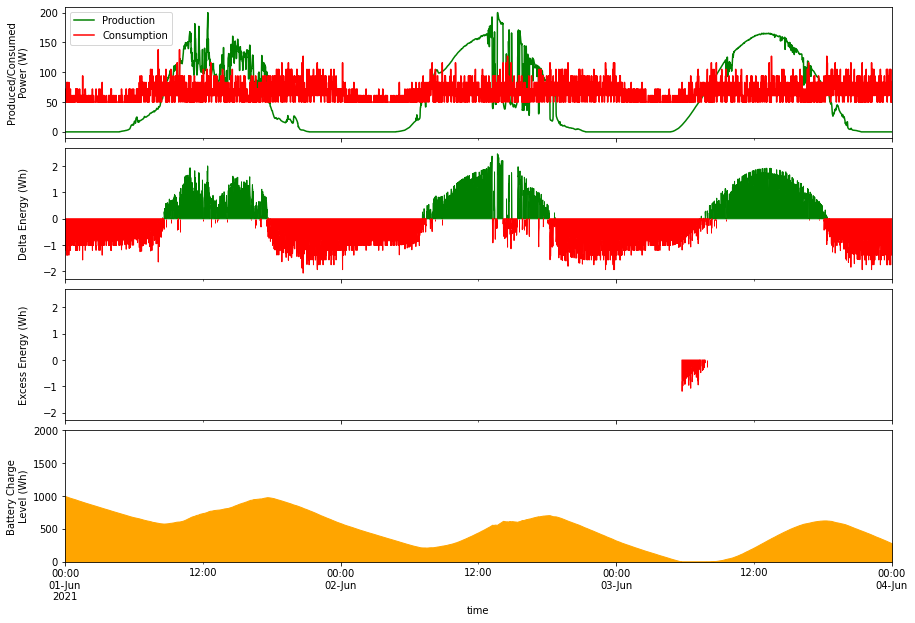

In [11]:
# Only plot first thre days
measurements_df = measurements_df[:"2021-06-04 00:00:00"]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,8))
fig.tight_layout(pad=0)

measurements_df["production_power"].plot(ax=ax1, color="green", label="Production")
measurements_df["consumption_power"].plot(ax=ax1, color="red", label="Consumption")
ax1.set_ylabel("Produced/Consumed\nPower (W)")
ax1.legend()

x = measurements_df["delta_energy"]
x.plot(ax=ax2, alpha=0)  # this call improves performance
ax2.fill_between(x.index, 0, x.values, where=x.values>0, color="green")
ax2.fill_between(x.index, 0, x.values, where=x.values<0, color="red")
ax2.set_ylabel("Delta Energy (Wh)")

x = measurements_df["excess_energy"]
x.plot(ax=ax3, alpha=0)  # performance
ax3.fill_between(x.index, 0, x.values, where=x.values>0, color="green")
ax3.fill_between(x.index, 0, x.values, where=x.values<0, color="red")
ax2.sharey(ax3)
ax3.set_ylabel("Excess Energy (Wh)")

x = measurements_df["battery_charge_level"]
x.plot(ax=ax4, alpha=0)  # performance
ax4.fill_between(x.index, 0, x.values, color="orange")
ax4.set_ylim(0, BATTERY_CAPACITY)
ax4.set_ylabel("Battery Charge\nLevel (Wh)")

fig.align_ylabels()

## Advanced Battery Simulation

In case you are interested in more sophisticated battery simulation, feel free to improve the simple battery model, e.g. via advanced battery simulators such as [PyBaMM](https://github.com/pybamm-team/PyBaMM).

In [1]:
import pybamm

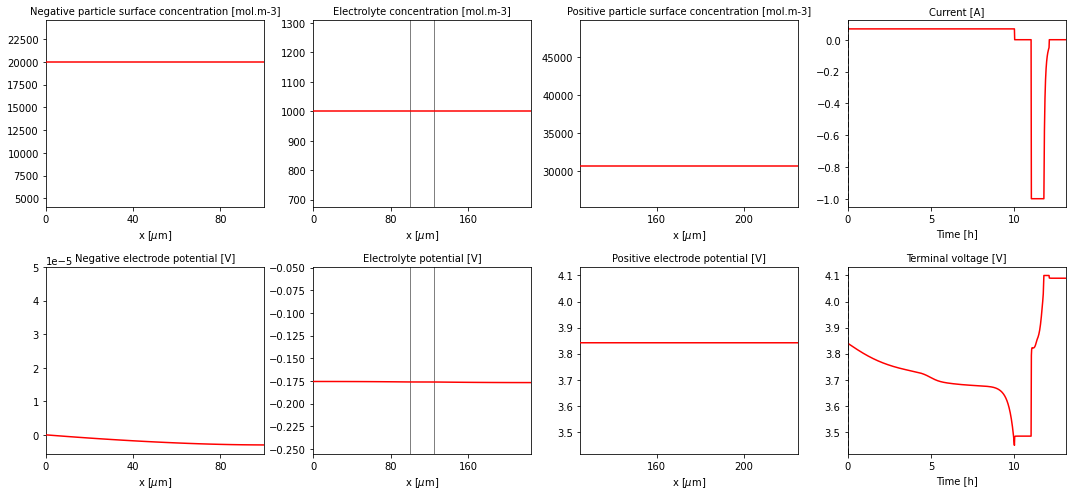

In [2]:
experiment = pybamm.Experiment(
    [
        "Discharge at C/10 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour",
    ]
)

model = pybamm.lithium_ion.DFN()

sim = pybamm.Simulation(model, experiment=experiment)

sim.solve()
sim.plot()

# Have fun!

In case of questions approach Philipp (wiesner@tu-berlin.de)!